# Use python to make a seqlogo from a multiple sequence alignment

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tijeco/personal_website/blob/master/content/post/seqlogo_from_multiple_sequence_alignment/index.ipynb)

A sequence logo, otherwise referred to as a seqlogo, is a common graphical representation technique used to visualize patterns of sequence conservation in nucleotide or protein sequences. A key component of a seqlogo is a multiple sequence alignment. A multiple sequence alignment has every character in the sequence a fixed sized matrix such that the states of each character in a given column are assumed to be homologous for each sequence in the row of the matrix. Homology in this regard means that each character shares a common ancestor. The particular details of multiple sequence alignments and homology will be discussed in greater detail later, but suffice to say they are a critical component for making seqlogos. We can use biopython to parse multiple sequence alignment data, for this example I will be using the T7-like virus holin protein family.


If you click on the following you can get the sequences I retrieved.
https://www.uniprot.org/uniref/?query=uniprot:(family%3A%22t7likevirus+holin+family%22)+identity:1.0
Simply press all, then press align to generate the multiple sequence alignment, an you can download it as a plain text file. Alternatively, you can just use the alignment file that I have provided [here]().


## Install software dependencies

There are three main software packages we willl need to install
1. **Biopython:** parses alignment data
2. **pandas:** stores amino acid freqeuncy of alignment
3. **seqlogo:** plots seqlogo

In [ ]:
!pip install biopython pandas seqlogo

Additionally, we will need to install ghostscript and pdf2svg, which can be installed easily on colab using apt-get.

In [ ]:
!apt-get install ghostscript pdf2svg

## Load libraries

In [ ]:
from Bio import AlignIO
import pandas as pd
import seqlogo

## Load alignment data

In [ ]:
t7_alignmentFile = "T7.family.aln"
t7_alignment = AlignIO.read(t7_alignmentFile, "clustal")
t7_alignment

<<class 'Bio.Align.MultipleSeqAlignment'> instance (89 records of length 78) at 7fc999c73690>

So the alignment has 89 sequences and 78 columns.

## Calculate amino acid frequency

For each of the 78 sites in the alignment we need to calculate the frequency of each of the 20 amino acids

The most straightforward way to do this is to just tally up the residues and store them in a dataframe. We will do this using the function `alnCompositionDF()`

In [ ]:
def alnSiteCompositionDF(aln, characters="ACDEFGHIKLMNPQRSTVWY"):
  alnRows = aln.get_alignment_length()
  compDict = {char:[0]*alnRows for char in characters}
  for record in aln:
    header = record.id
    seq = record.seq
    for aaPos in range(len(seq)):
      aa = seq[aaPos]
      if aa in characters:
        compDict[aa][aaPos] += 1    
  return pd.DataFrame.from_dict(compDict)

In [ ]:
t7_alignmentSiteCompDF = alnSiteCompositionDF(t7_alignment)
t7_alignmentSiteCompDF

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0
3,0,0,0,0,0,4,0,0,0,0,79,0,0,0,0,6,0,0,0,0
4,0,0,0,0,0,0,0,12,0,77,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0,0,1,2,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
74,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
76,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


So for each site in the alignment we have a tally for all the amino acids, now we just need to calculate the proportion of each residue per site so that all the values in each row add to one.

In [ ]:
t7_alignmentSiteFreqDF = t7_alignmentSiteCompDF.div(t7_alignmentSiteCompDF.sum(axis=1), axis=0)
t7_alignmentSiteFreqDF

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.285714,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.714286,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.300000,0.0,0.000000,0.0,0.0,0.000000,0.2,0.000000,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.044944,0.0,0.000000,0.0,0.000000,0.887640,0.0,0.000000,0.0,0.0,0.067416,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.134831,0.0,0.865169,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.000000,0.0,0.166667,0.333333,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.166667,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0
74,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.5,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
75,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
76,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


Now we can take this and make our seqlogo!

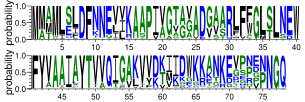

In [ ]:
t7_alignmentSiteFreqSeqLogo= seqlogo.Ppm(t7_alignmentSiteFreqDF,alphabet_type="AA")
seqlogo.seqlogo(t7_alignmentSiteFreqSeqLogo, ic_scale = False, format = 'svg', size = 'large')


There you have it! A sequence logo from a multiple sequnece alignment!

# Wrapping up and things to consider

So this is just a slight introduction to a technique that is useful for visualizing multiple sequence alignments. It is far from an exhaustive approach, but will hopefully serve as a helpful template. 

There are always improvements to be made, so on your own you can think about and consider what improvements you would make to the function, and think about possible problems. For instance, think about the following:

1. How could this be expanded to deal with nonstandard amino acids? 
  * What happens if we use the function I provided with data that has nonstandard amino acids
2. Are there ways to modify the color of the residues?
3. Can residues belonging to certain domains be highlighted somehow?